# FBI NICS Firearm Background Check Data Exploration

## About this Dataset

The data in this repository comes from the [FBI's National Instant Criminal Background Check System](https://www.fbi.gov/services/cjis/nics). The National Instant Criminal Backgroung Check System, or NICS, was launched by the FBI in November 1998 and is used by Federal Firearms Licensees (FFLs) to quickly determine whether a customer is eligible to buy firearms or explosives. Before completeing the sale of a firearm, dealers must first determine whether or not the customer has a criminal record or is otherwise ineligible to own a firearm. Based on the most current statistics, between two and three million of these background checks are performed on a monthly basis throughout the United States.

The data begins in November of 1998 and contains every NICS background check by month and state until present day, March 2019. 

#### Some notes on the data:
These numbers do not include private gun sales, which often do not require a background check. It is important to note then that a study by Harvard researchers reported that about 40 percent of respondants had acquired their most recent firearm without having to go through a background check. If this number is representative of the number of background checks being performed versus the number of firearms being sold, the data from the FBI gives a very skewed representation of how many firearms are sold in the US on a monthly basis--those numbers would be nearly double the numbers from this dataset. 

Not all of these background checks are for the sale of firearms; many of them are for the issuance of permits.
Firearm sale laws vary from state to state as well, with some states, such as Kentucky, who has a law requiring a re-check every month for concealed carry permits, being over represented in the data. The FBI also notes that "Some states may reflect lower than expected numbers for handgun checks based on varying state laws pertaining to handgun permits. Since the permit check is done in place of the NICS check in most of the affected states, the low handgun statistics are often balanced out by a higher number of handgun permit checks."

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import seaborn as sb

BgChecks = pd.read_csv('nics-firearm-background-checks.csv',encoding = 'ISO-8859-1')

## Total Background Checks across the United States

Before we get into background checks in individual states or attempt to use this data to model the number of *guns sold* in the US, let's look at the big picture--every type of background check throughout the entire country. 

This first graph shows the most recent data we have on background checks in the US. This graph represents the sales from the past three years: March 2016 to March 2019.

(0, 35)

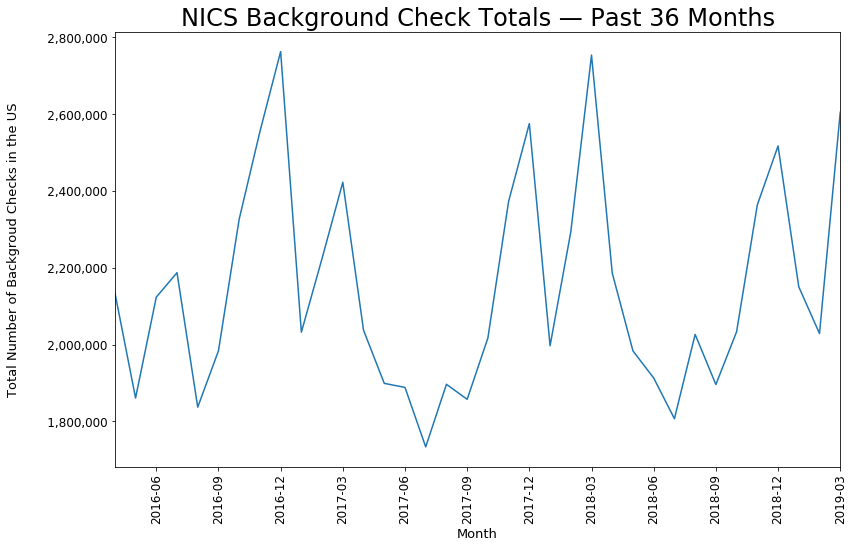

In [2]:
# Parsing data and plotting with seaborn
df = pd.DataFrame(BgChecks)

# Parsing month and year strings
BgChecks["year_int"] = BgChecks["month"].apply(lambda x: int(x.split("-")[0]))
BgChecks["month_int"] = BgChecks["month"].apply(lambda x: int(x.split("-")[1]))

latest_month_count = BgChecks.iloc[0]["month_int"] + (BgChecks.iloc[0]["year_int"] * 12)

# Adding up US totals for each month for the past 36 months
totals = BgChecks[(BgChecks["month_int"] + (BgChecks["year_int"] * 12)) > (latest_month_count - 12*3)].groupby("month")["totals"].sum()

df.set_index("year_int", inplace=True)

# Setting up the plot
plt.figure(figsize=(13,8))
#ax = sb.lineplot(x="month", y="totals", data=BgChecks)
ax = sb.lineplot(x=totals.index.values, y=totals)

tick_placement = pd.np.arange(len(totals) - 1, 0, -3)

ax.set_title("NICS Background Check Totals — Past 36 Months", fontsize=24)
ax.set_xlabel("Month", fontsize=13)
ax.set_ylabel("Total Number of Backgroud Checks in the US", fontsize=13)

ax.set_xticks(tick_placement)
ax.set_xticklabels([ totals.index[i] for i in tick_placement ])

plt.setp(ax.get_xticklabels(), rotation=90, fontsize=12)

ax.set_yticklabels([ "{0:15,.0f}".format(y) for y in ax.get_yticks() ], fontsize=12)
ax.set_xlim(0, len(totals) - 1)

The graph below gives a more comprehensive look at background checks performed throughout the US over the years since the NICS was born. It shows a distinctive upward trend that starts in 2006. Before 2006, the number of background checks appears to be relatively consistent. The large spikes in background checks at the end of each year is an interesting phenomenon as well--are there more gun sales towards the end of the year, or more background checks filed for some sort of clerical reason? Further research is needed to answer this question. The dramatic spikes in the number of background checks in years such as 2013 and 2016 are likely best explained by the addition of new background check laws either nationally or in particular states. It is interesting to note that the second deadliest school shooting, the Sandy Hook Elementary School shooting, occurred in Dec 2012. This would explain the huge spike in background checks in 2013, when fears about the mentally ill obtaining guns rose swiftly. At the beginning of 2016 President Obama issued an [executive order](https://www.nytimes.com/2016/01/06/us/politics/obama-gun-control-executive-action.html?module=inline) regarding gun control. In June of 2016, 49 people were killed at an Orlando night club, which at the time was the deadliest mass shooting by a single shooter in U.S. history. In October 2017 it was surpassed by the Las Vegas shooting where 58 people were killed and 422 were wounded. Not all states participate fully in the national background check system either, and some states rely solely on thier state government for background checks. Let's look at the background check data organized by state to see if we can glean anything new from it. 

(0, 244)

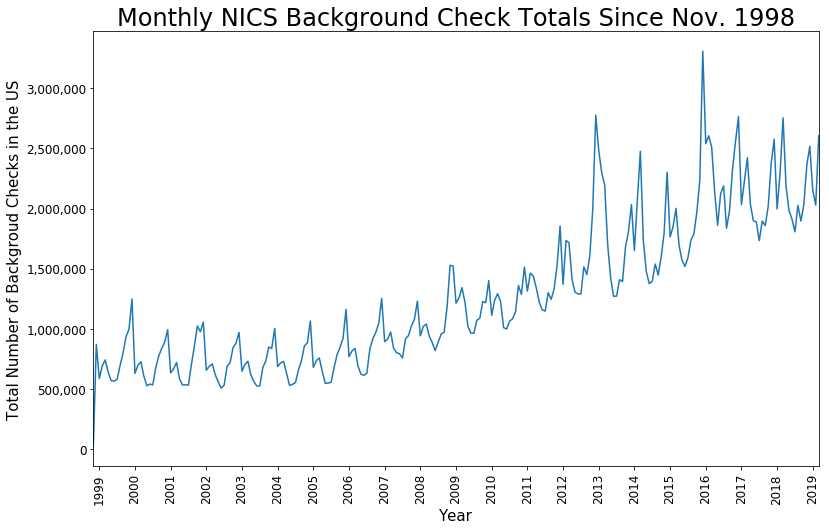

In [3]:
# Adding up the totals for each year
totals = BgChecks.groupby("month")["totals"].sum()

# Setting up the plot
tick_placement = pd.np.arange(2, len(totals), 12)
plt.figure(figsize=(13,8))
ax = sb.lineplot(x=totals.index.values, y=totals)

ax.set_title("Monthly NICS Background Check Totals Since Nov. 1998", fontsize=24)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Total Number of Backgroud Checks in the US", fontsize=15)

ax.set_yticklabels([ "{0:,.0f}".format(y) for y in ax.get_yticks() ], fontsize=12)

plt.setp(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_xticks(tick_placement)

ax.set_xticklabels([ totals.index[i].split("-")[0] for i in tick_placement ])
ax.set_xlim(0, len(totals) - 1)

In [4]:
# Adding up each state's total background checks since 1998
st_totals = BgChecks.groupby('state',as_index=False)["totals"].sum()

# Loading file with 50 states and their abbreviations
state_abbr = pd.read_csv('states.csv',encoding = 'ISO-8859-1')
abbr_df = pd.DataFrame(state_abbr)

# Masking the 5 territories the background check data has but the gun death data doesn't
territories = ('District of Columbia', 'Guam', 'Puerto Rico', 'Mariana Islands', 'Virgin Islands')

mask = np.logical_not(st_totals.state.isin(territories))
no_terr = st_totals[mask]
abbr_df.rename(columns={'State':'state'}, inplace=True)

# Joining the two data sets (using full state name as overlap) so the gun death data now has state abbreviations as well
joinedStateDeaths = pd.merge(abbr_df, no_terr, how='inner', on=['state'], right_index=True)
#print(joinedStateDeaths)

## Total Background Checks by Individual State

I'm curious to see if background checks have any effect on number of gun deaths in each state and if we can tell whether or not stricter background checks help to control not only the purchase and sale of firearms, but help to keep gun murder rates down. Are stricter background checks the answer to our gun control problem, or do they not have any effect at all? I hope to answer these questions in the next few exploratory graphs.

In the bar graph below the number of background checks in each state are represented in order of smallest to largest population. Note that the states are grouped into three categories: Full POC, Partial POC, and Non POC. With these points of comparison we notice that the number of background checks in each state heavily correlates with population. The one major outlier is Kentucky becuase it is one of few states in the country that performs background checks on concealed carry permits on a monthly basis. A [2015 analysis](https://wfpl.org/kentucky-background-checks-stand-out/) reported that nearly 90% of the background checks performed in Kentucky were monthly concealed carry permit re-checks. The other states that stand out to me as outliers are New York, New Jersey, Massachusetts, and Maryland, but their POC-statuses don't seem to correlate to their lack of background checks recorded.

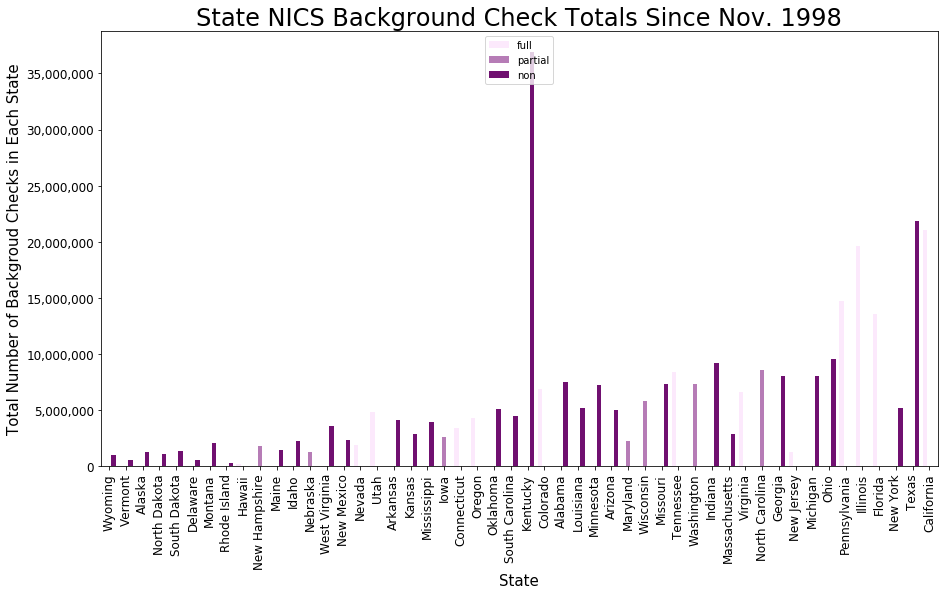

In [5]:
# Plotting the bar graph
plt.figure(figsize=(15,8))
ax = sb.barplot(x='state', y='totals', data=joinedStateDeaths, color='purple', order=['Wyoming','Vermont','Alaska','North Dakota','South Dakota','Delaware','Montana','Rhode Island','Hawaii','New Hampshire','Maine','Idaho','Nebraska','West Virginia','New Mexico','Nevada','Utah','Arkansas','Kansas','Mississippi','Iowa','Connecticut','Oregon','Oklahoma','South Carolina','Kentucky','Colorado','Alabama','Louisiana','Minnesota','Arizona','Maryland','Wisconsin','Missouri','Tennessee','Washington','Indiana','Massachusetts','Virginia','North Carolina','Georgia','New Jersey','Michigan','Ohio','Pennsylvania','Illinois','Florida','New York','Texas','California'],hue='Category', hue_order=['full', 'partial', 'non'])
# Rotating x tick labels so state names don't overlap
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=12)

# Changing y tick labels to millions instead of scientific notation
ax.set_yticklabels([ "{0:,.0f}".format(y) for y in ax.get_yticks() ], fontsize=12)

ax.set_title("State NICS Background Check Totals Since Nov. 1998", fontsize=24)
ax.set_xlabel("State", fontsize=15)
ax.set_ylabel("Total Number of Backgroud Checks in Each State", fontsize=15)
leg = ax.legend();

Let's go over some useful information and terms regarding individual states' compliance. There are three levels of participation in the NICS: 
    In states where the state government does not serve as a point of contact (POC) for background checks, Federal Firearms Licensees (the sellers, or FFLs) initiate a NICS background check by contacting the NICS Section for *all* firearm transfers. The NICS Section conducts the NICS checks and determines whether the transfer would violate state or federal law. These states are called **non-POC** states. 
    In states where the state government has agreed to serve as a POC for handgun transfers but not for long gun transfers (**partial POC**), FFLs contact the state for handgun transfers. FFLs in those states must contact the NICS Section for long gun transfers.
    In states where the state government has agreed to serve as a POC for both handgun and long gun transfers (**full POC**), FFLs contact the state for *all* firearm transfers. The POC initiates the NICS checks and determines whether the transfers would violate state or federal law. The map below is useful in determining which states are which.
    
<img src="NICS State Participation.png">

- **Full POC states** (contact state/territory for all firearm background checks, including permits): **California**, Colorado, Connecticut, Florida, **Hawaii**, Illinois, **Nevada**, New Jersey, Oregon, Pennsylvania, Tennessee, **Utah**, and Virginia.

- **Partial POC states** (contact state for handgun and FBI for long gun background checks): Maryland, New Hampshire, Washington, and Wisconsin.
- **Partial POC states** (contact state for handgun permit and FBI for long gun background checks): **Iowa**, **Nebraska**, and **North Carolina**.

- **Non-POC states/territories** (contact FBI directly for all firearm background checks): **Alabama**, **Alaska**, American Samoa, **Arizona**, **Arkansas**, Delaware, District of Columbia, **Georgia**, Guam, **Idaho**, Indiana, **Kansas**, **Kentucky**, **Louisiana**, Maine, Massachusetts, **Michigan**, Minnesota, **Mississippi**, Missouri, **Montana**, New Mexico, New York, **North Dakota**, Northern Mariana Islands, **Ohio**, Oklahoma, Puerto Rico, Rhode Island, **South Carolina**, **South Dakota**, **Texas**, Vermont, Virgin Islands, **West Virginia**, and **Wyoming**. 

Twenty-six states have at least one ATF-qualified alternate permit, which are issued by local or state agencies. These states are in **bold**. These are states in which permits qualify as alternatives to the background check requirements of the Brady law. The list of states with their alternative permits can be found [here](https://www.atf.gov/rules-and-regulations/permanent-brady-permit-chart). This information is important to our data because it gives context to states that might have a skewed number of background checks recorded because of the laws regarding background checks in those states. 

In that same vein, let's look at some more data on gun violence by state in comparison with number of background checks performed. Just to be comprehensive, we also pull some additional data on population and gun ownership by state to see which has the highest correlation with rate of gun deaths. The population data comes from the offical [US Census Bureau website](https://www.census.gov/programs-surveys/decennial-census/decade.2010.html) and is compiled nicely here on [this](https://en.wikipedia.org/wiki/Firearm_death_rates_in_the_United_States_by_state) Wikipedia page in Table 3. The gun death data is calculated from the [FBI's Unified Crime Reporting data](https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/tables/10tbl20.xls) from 2010. Gun ownership data was taken from [this study](https://injuryprevention.bmj.com/content/22/3/216.full) done in 2013.

First, let's compare the number of background checks per state to the number of gun deaths in each state. We will exclude any data from the District of Columbia and other US territories and focus on the 50 states for the sake of uniformity and data completeness. First we plot the 50 states as a scatter plot and see that the scale makes it so most states are clumped in the corner and we can't even tell which dot is from which state. Because there are such extreme outliers as KY and CA, we'll take the square root of the data to scale it down a bit.

In [6]:
# Joining data sets and plotting
stateStats = pd.read_csv('state statistics.csv',encoding = 'ISO-8859-1')
abbr_df.rename(columns={'state':'State'}, inplace=True)

# Join table with abbreviations using state name
stats_abbr = pd.merge(abbr_df, stateStats, how='inner', on=['State'])

# Number of background checks per state in 2010
year2010 = BgChecks[BgChecks['year_int'] == 2010]
states2010 = year2010.groupby('state',as_index=False)["totals"].sum()

# Masking the 5 territories the background check data has but the gun death data doesn't
territories = ('District of Columbia', 'Guam', 'Puerto Rico', 'Mariana Islands', 'Virgin Islands')

mask = np.logical_not(states2010.state.isin(territories))
no_terr2010 = states2010[mask]

# Adding the 2010 background checks by state to df
stats_abbr.rename(columns={'State':'state'}, inplace=True)
joinedStateChecks2010 = pd.merge(stats_abbr, no_terr2010, how='inner', on=['state'], right_index=True)
#print(joinedStateChecks2010)

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

# Plot number of background checks vs gun deaths
trace1 = go.Scatter(
    x=np.sqrt(joinedStateChecks2010['Total Gun Deaths']),
    y=np.sqrt(joinedStateChecks2010['totals']),
    mode='markers+text',
    name='Lines, Markers and Text',
    text=joinedStateChecks2010['Abbreviation'],
    textposition='top center'
)

m,b = np.polyfit(np.sqrt(joinedStateChecks2010['Total Gun Deaths']), np.sqrt(joinedStateChecks2010['totals']), 1)
bestfit_y = ((np.sqrt(joinedStateChecks2010['Total Gun Deaths'])) * m + b)

lineOfBestFit=go.Scatter(
    x=np.sqrt(joinedStateChecks2010['Total Gun Deaths']),
    y=bestfit_y,
    name='Line of best fit',
    line=dict(
        color='red',
    )
)

data = [trace1, lineOfBestFit]

layout= go.Layout(
    title= 'Total Gun Deaths Per State vs Total Background Checks Per State in 2010',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Gun Deaths',
    ),
    yaxis=dict(
        title= 'Background Checks',
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Something important to note here might be that there is also a heavy correlation between the number of background checks in a state and the state's population. So the real indicator of number of gun deaths in each state might actually be population and not the number of background checks performed, as they are essentially the same thing. This is somewhat of the opposite of what we would 'expect' -- more background checks means fewer gun deaths. A better analysis of the correlation between the two might be background checks per capita vs gun deaths per capita in each state.

Let's add a line of best fit so we can really see the pattern here. There are two major outliers as far as I can tell, UT and KY, but we already know that KY is going to be an outlier when it comes to background checks becuase they have that law that re-checks permits every month. I suspect if we researched Utah's background check laws we would find similar circumstances.  

Now let's compare the total gun deaths in each state to the population density of each state. Are there more gun deaths in more densely populated states, or does population density not have anything to do with gun violence? Again we take the square root of the data to spread the points out a bit.

In [8]:
# Plot total gun deaths against population density
trace2 = go.Scatter(
    x=np.sqrt(stats_abbr['Total Gun Deaths']),
    y=np.sqrt(stats_abbr['Population density  (inhabitants per square mile)']),
    mode='markers+text',
    name='Lines, Markers and Text',
    text=stats_abbr['Abbreviation'],
    textposition='top center'
)


m,b = np.polyfit(np.sqrt(joinedStateChecks2010['Total Gun Deaths']), np.sqrt(joinedStateChecks2010['Population density  (inhabitants per square mile)']), 1)
bestfit_y = ((np.sqrt(joinedStateChecks2010['Total Gun Deaths'])) * m + b)

lineOfBestFit=go.Scatter(
    x=np.sqrt(joinedStateChecks2010['Total Gun Deaths']),
    y=bestfit_y,
    name='Line of best fit',
    line=dict(
        color='red',
    )
)

data = [trace2, lineOfBestFit]

layout= go.Layout(
    title= 'Total Gun Deaths Per State vs Population Density in 2010',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Gun Deaths',
    ),
    yaxis=dict(
        title= 'Popluation Density (Inhabitants per sq mi)',
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Ah, much better. Now we can actually see relatively easily where each state falls on the graph without undermining our visual representation. There is a slight upward trend indicating that a higher population density leads to more gun deaths, but there are also many outliers such as RI, DE, CT, MA, NJ, MD, HI, NH, VT, FL, TX, and CA. However, it is interesting to note that among the outliers there are similar characteristics: FL, TX, and CA are all very large in size and therefore not as densely populated as RI, DE, CT, MA, NJ, and MD. It makes sense then that because their populations are so high that they would have more gun deaths than the smaller states but since their land mass is so large they are not very densely populated. The opposite goes for RI, DE, CT, MA, NJ, and MD. They are very densely populated because their land masses are so small, but their populations still pale in comparison to those of FL, TX, and CA. The interesting outliers to note here are VT, NH, and HI. These three states all have some of the lowest numbers in terms of gun deaths, yet they are more densely populated than other states with low gun deaths. Might this have something to do with the background check laws in these states, or do just fewer people own guns in these states for community and cultural reasons? Further research is needed to answer this question.

In [11]:
# With no square root

#trace3 = go.Scatter(
#    x=stats_abbr['Gun murders  (rate per 100,000 inhabitants)'],
#    y=stats_abbr['Population density  (inhabitants per square mile)'],
#    mode='markers+text',
#    name='Lines, Markers and Text',
#    text=stats_abbr['Abbreviation'],
#    textposition='top center'
#)

#data = [trace3]

#layout= go.Layout(
#    title= 'Gun Murder Rate vs Population Density in 2010',
#    hovermode= 'closest',
#    xaxis= dict(
#        title= 'Gun Murders (Rate per 100,000 Inhabitants)',
#    ),
#    yaxis=dict(
#        title= 'Popluation Density (Inhabitants per sq mi)',
#    ),
#    showlegend= False
#)

#fig = go.Figure(data=data, layout=layout)
#iplot(fig)

While the previous graph gives us some information, it makes more sense to compare the murder rate to the population density in each state instead of the total gun deaths. The murder rate takes into account the population of each state whereas total gun deaths is likely larly effected by the population in each state. Larger population equals more gun deaths but we want to know if a more dense population correlates at all to the murder rate, not just the sheer numbers. These two graphs will have some similarities, but their differences are what will be the most revealing.

In [12]:
# Plot gun murder rate against population density (with square root)
trace3 = go.Scatter(
    x=np.sqrt(stats_abbr['Gun murders  (rate per 100,000 inhabitants)']),
    y=np.sqrt(stats_abbr['Population density  (inhabitants per square mile)']),
    mode='markers+text',
    name='Lines, Markers and Text',
    text=stats_abbr['Abbreviation'],
    textposition='top center'
)

data = [trace3]

layout= go.Layout(
    title= 'Gun Murder Rate vs Population Density in 2010',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Gun Murders (Rate per 100,000 Inhabitants)',
    ),
    yaxis=dict(
        title= 'Popluation Density (Inhabitants per sq mi)',
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

The first major difference I notice between the first and second graphs is Louisiana's position on the map--it's gun murder rate is WAY higher than the rest of the states, whereas before TX, CA, and FL were the clear leaders. There isn't as severe of an upward trend as the first graph, but there is definitely something that points to population density as a cause of more gun deaths. There are quite a few outliers like AK, NM, NV, RI, MA, CT, NJ, MO, and LA, but I do see an upward trend. Lastly, let's examine what affect gun ownership rates has on gun murder rates in each state. In theory, if there are more (stricter) background checks, there should be fewer guns, and therefore fewer gun murders. Does this theory hold true?

In [19]:
# Plot gun murder rate vs gun ownership

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)


trace4 = go.Scatter(
    x=(stats_abbr['Gun murders  (rate per 100,000 inhabitants)']),
    y=(stats_abbr['Gun ownership (%)']),
    mode='markers+text',
    name='Lines, Markers and Text',
    text=stats_abbr['Abbreviation'],
    textposition='top center'
)

data = [trace4]

layout= go.Layout(
    title= 'Gun Murder Rate vs Percent of Population Owning Guns',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Gun Murders (Rate per 100,000 Inhabitants)',
    ),
    yaxis=dict(
        title= 'Gun Ownership (%)',
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Well, this is disappointing. There seems to be no correlation at all between the percent of each state owning guns vs the gun murder rate. Gun ownership and population density seem to correlate more strongly than gun ownership and gun murder rates. I think that we would see the greatest correlation between percent ownership of illegally obtained guns and the gun murder rate. Just because a state has more legally obtained guns does not mean the murder rate will go up, in fact I would think that leagally obtaining a gun would actually deter you from committing a crime with that weapon becasue it can very easily be traced back to you.

In [20]:
# Plot population density vs gun ownership
trace5 = go.Scatter(
    x=np.sqrt(stats_abbr['Population density  (inhabitants per square mile)']),
    y=np.sqrt(stats_abbr['Gun ownership (%)']),
    mode='markers+text',
    name='Lines, Markers and Text',
    text=stats_abbr['Abbreviation'],
    textposition='top center'
)

data = [trace5]

layout= go.Layout(
    title= 'Population Density vs Percent of Population Owning Guns',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Population Density (inhabitants per square mile)',
    ),
    yaxis=dict(
        title= 'Gun Ownership (%)',
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

As a bonus, I compared gun ownership to population density, and as expected, the less dense (read: more rural) the population, the greater the percentage of gun ownership. In conclusion, just because background checks are stricter does not mean it's necessarily harder to obtain a firearm without one. Anyone who doesn't intend on committing a crime would have no problem going through the background check process, and anyone that does will simply go through a private sale. I believe the lesson here is that in order for the rate of gun violence to go down, guns need to be harder to obtain from ANY source, not just legal sources. If someone really wants a gun--they can, and will, get their hands on one regardless of the strictness of background checks on legally obtained weapons.

## Questions for Further Research

- Do background checks work? Do they reduce gun casualties?
https://annals.org/aim/fullarticle/2595892/firearm-acquisition-without-background-checks-results-national-survey
- Are there fewer gun deaths in states with stricter background check/gun laws?
- Population growth vs background check growth, have background check laws gotten stricter and more prolific, or can the increase just be explained by a growing population?
- Compare gun murder/death rates before and after NICS Brady Law
- How does each state's political lean affect the gun death rate? Do red states have fewer or more gun deaths per capita?
- We only examine the gun murder rate, what about the total gun death rate? Do background checks have a different effect on rate of self-inflicted harm?
- What percentage of crimes are committed with illegally obtained firearms